##### AI/LLM Disclaimer
I used Claude, Anthropic's model to help with the code portion of this assignment.
I used Copilot for help understanding these concepts.

(1) Collect time series data on at least two variables and discuss why those variables might be cointegrated. 

* Perform ADF tests on the data and the differenced data to determine if it is stationary or I(1). 
* Perform the Johansen procedure to determine the number of cointegrating vectors in the system.
* Estimate a VAR or VECM based on the results of the ADF tests and Johansen procedure.
* Make assumptions to identify structural shocks.
* Explain why this requires assumptions and how those assumptions lead to the identification of structural shocks.
* Display at least one IRF chart based on a structural shock and interpret it.


##### Imports

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR


##### Original Dataset's Descriptions

##### GDP:

Units:
Billions of Dollars,
Seasonally Adjusted Annual Rate

Frequency:
Quarterly

##### PCE:

Units:

Billions of Dollars,
Seasonally Adjusted Annual Rate

Frequency:
Quarterly

In [18]:
df_gdp = pd.read_csv('../datasets/assignment9/GDP.csv')
df_pce = pd.read_csv('../datasets/assignment9/PCE.csv')

print('df_gdp:\n', df_gdp.head(5))
print('df_pce:\n', df_pce.head(5))

print('df_gdp:\n', df_gdp.tail(5))
print('df_pce:\n', df_pce.tail(5))

df_gdp:
   observation_date      GDP
0       1947-01-01  243.164
1       1947-04-01  245.968
2       1947-07-01  249.585
3       1947-10-01  259.745
4       1948-01-01  265.742
df_pce:
   observation_date    PCE
0       1959-01-01  306.1
1       1959-02-01  309.6
2       1959-03-01  312.7
3       1959-04-01  312.2
4       1959-05-01  316.1
df_gdp:
     observation_date        GDP
309       2024-04-01  29147.044
310       2024-07-01  29511.664
311       2024-10-01  29825.182
312       2025-01-01  30042.113
313       2025-04-01  30485.729
df_pce:
     observation_date      PCE
795       2025-04-01  20746.4
796       2025-05-01  20755.0
797       2025-06-01  20868.4
798       2025-07-01  20982.7
799       2025-08-01  21111.9


The earliest date that gdp has is 1947, and pce is 1959, so let’s put the date min at 1959-01-01, and the max will be 2025-04-01 because that is the most recent entry for gdp.
The ADF tests can be ran separately on their own datasets, but the Johansen test, VAR/VECM, and structural shocks/IRFS need to be under the same dataset with the same datetime index.
So, let's do that before we start analyzing cointegration. Also, we need to fix the monthly/quarterly frequency so that the datasets work with each other.

##### Data Cleaning/Merging

In [19]:
# Ensure datetime index
df_gdp['observation_date'] = pd.to_datetime(df_gdp['observation_date'])
df_pce['observation_date'] = pd.to_datetime(df_pce['observation_date'])

df_gdp = df_gdp.set_index('observation_date')
df_pce = df_pce.set_index('observation_date')

# Clip to range
start, end = '1959-01-01', '2025-04-01'
df_gdp = df_gdp.loc[start:end]
df_pce = df_pce.loc[start:end]

# Resample PCE to quarterly (quarter start to match GDP)
df_pce_q = df_pce.resample('QS').mean()

# Merge
df_merged = pd.merge(df_gdp, df_pce_q, left_index=True, right_index=True, how='inner')

print('merged_df:\n', df_merged.head())
print()
print('merged_df:\n', df_merged.tail())


merged_df:
                       GDP         PCE
observation_date                     
1959-01-01        510.330  309.466667
1959-04-01        522.653  315.500000
1959-07-01        525.034  320.733333
1959-10-01        528.600  322.866667
1960-01-01        542.648  326.366667

merged_df:
                         GDP           PCE
observation_date                         
2024-04-01        29147.044  19756.066667
2024-07-01        29511.664  20032.800000
2024-10-01        29825.182  20351.300000
2025-01-01        30042.113  20555.000000
2025-04-01        30485.729  20746.400000


Printing the df_gdp, and df_pce_q head(5), and tail(5) to make sure that they did get cleaned appropriately.

In [20]:
print('df_gdp:\n', df_gdp.head(5))
print('df_pce_q:\n', df_pce_q.head(5))

print('df_gdp:\n', df_gdp.tail(5))
print('df_pce_q:\n', df_pce_q.tail(5))

df_gdp:
                       GDP
observation_date         
1959-01-01        510.330
1959-04-01        522.653
1959-07-01        525.034
1959-10-01        528.600
1960-01-01        542.648
df_pce_q:
                          PCE
observation_date            
1959-01-01        309.466667
1959-04-01        315.500000
1959-07-01        320.733333
1959-10-01        322.866667
1960-01-01        326.366667
df_gdp:
                         GDP
observation_date           
2024-04-01        29147.044
2024-07-01        29511.664
2024-10-01        29825.182
2025-01-01        30042.113
2025-04-01        30485.729
df_pce_q:
                            PCE
observation_date              
2024-04-01        19756.066667
2024-07-01        20032.800000
2024-10-01        20351.300000
2025-01-01        20555.000000
2025-04-01        20746.400000


##### ADF Testing

In [21]:

# quick little helper function
def adf_test(series, name):
    result = adfuller(series.dropna())
    print(f'ADF Test for {name}')
    print(f'  Test Statistic : {result[0]}')
    print(f'  p-value        : {result[1]}')
    print(f'  #Lags Used     : {result[2]}')
    print(f'  #Observations  : {result[3]}')
    for key, value in result[4].items():
        print(f'  Critical Value {key} : {value}')
    print('  => Stationary' if result[1] < 0.05 else '  => Non-stationary')
    print()

# Run ADF on non-differenced data
adf_test(df_gdp['GDP'], 'GDP')
adf_test(df_pce_q['PCE'], 'PCE (Quarterly)')


ADF Test for GDP
  Test Statistic : 8.049936874382977
  p-value        : 1.0
  #Lags Used     : 1
  #Observations  : 264
  Critical Value 1% : -3.455365238788105
  Critical Value 5% : -2.8725510317187024
  Critical Value 10% : -2.5726375763314966
  => Non-stationary

ADF Test for PCE (Quarterly)
  Test Statistic : 7.808342073201177
  p-value        : 1.0
  #Lags Used     : 0
  #Observations  : 265
  Critical Value 1% : -3.4552699038400827
  Critical Value 5% : -2.8725092359464526
  Critical Value 10% : -2.5726152830188678
  => Non-stationary



In [22]:
# Take the first differences
gdp_diff = df_gdp['GDP'].diff()
pce_diff = df_pce_q['PCE'].diff()

# Run ADF on differenced series
adf_test(gdp_diff, 'GDP First Difference')
adf_test(pce_diff, 'PCE First Difference')

ADF Test for GDP First Difference
  Test Statistic : -3.734512814136
  p-value        : 0.0036530744094190265
  #Lags Used     : 4
  #Observations  : 260
  Critical Value 1% : -3.4557539868570775
  Critical Value 5% : -2.8727214497041422
  Critical Value 10% : -2.572728476331361
  => Stationary

ADF Test for PCE First Difference
  Test Statistic : -3.113365881319499
  p-value        : 0.02557973597406884
  #Lags Used     : 6
  #Observations  : 258
  Critical Value 1% : -3.455952927706342
  Critical Value 5% : -2.8728086526320302
  Critical Value 10% : -2.572774990685656
  => Stationary



Okay cool. We saw that the non-difference data was non-stationary and then once we took the first diff it made them stationary. This confirms that the timeseries data is indeed I(1) which satisfies the cointegration requirements. We will now begin on that.

Also, we no longer need to work with the datasets individually so we're switching over to the merged dataset we made earlier.

##### Johansen Testing

In [23]:

# Johansen test
johansen_test = coint_johansen(df_merged, det_order=0, k_ar_diff=1)

# Trace statistic and critical values
print("Trace Statistic:", johansen_test.lr1)
print("Trace Critical Values (90%, 95%, 99%):", johansen_test.cvt)

# Max-Eigen statistic and critical values
print("Max-Eigen Statistic:", johansen_test.lr2)
print("Max-Eigen Critical Values (90%, 95%, 99%):", johansen_test.cvm)


Trace Statistic: [69.15894038  9.31202974]
Trace Critical Values (90%, 95%, 99%): [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Max-Eigen Statistic: [59.84691064  9.31202974]
Max-Eigen Critical Values (90%, 95%, 99%): [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


So, as expected the two variables in the time-series data are cointegrated, and strongly so as the results from the Johansen tests show that for each statistic and value we reject the null.

##### VAR in levels: estimation, identification, and IRFs

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       27.05       27.08   5.581e+11       27.06
1       17.63      17.72*   4.555e+07       17.67
2       17.64       17.78   4.598e+07       17.70
3       17.64       17.83   4.588e+07       17.72
4       17.65       17.90   4.629e+07       17.75
5       17.53       17.84   4.122e+07       17.66
6       17.46       17.82   3.842e+07      17.61*
7       17.48       17.89   3.893e+07       17.64
8      17.45*       17.92  3.781e+07*       17.64
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 21, Nov, 2025
Time:                     10:44:29
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    17.9160
Nobs:                     258.000    

c:\Users\n0308g\python_venv\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


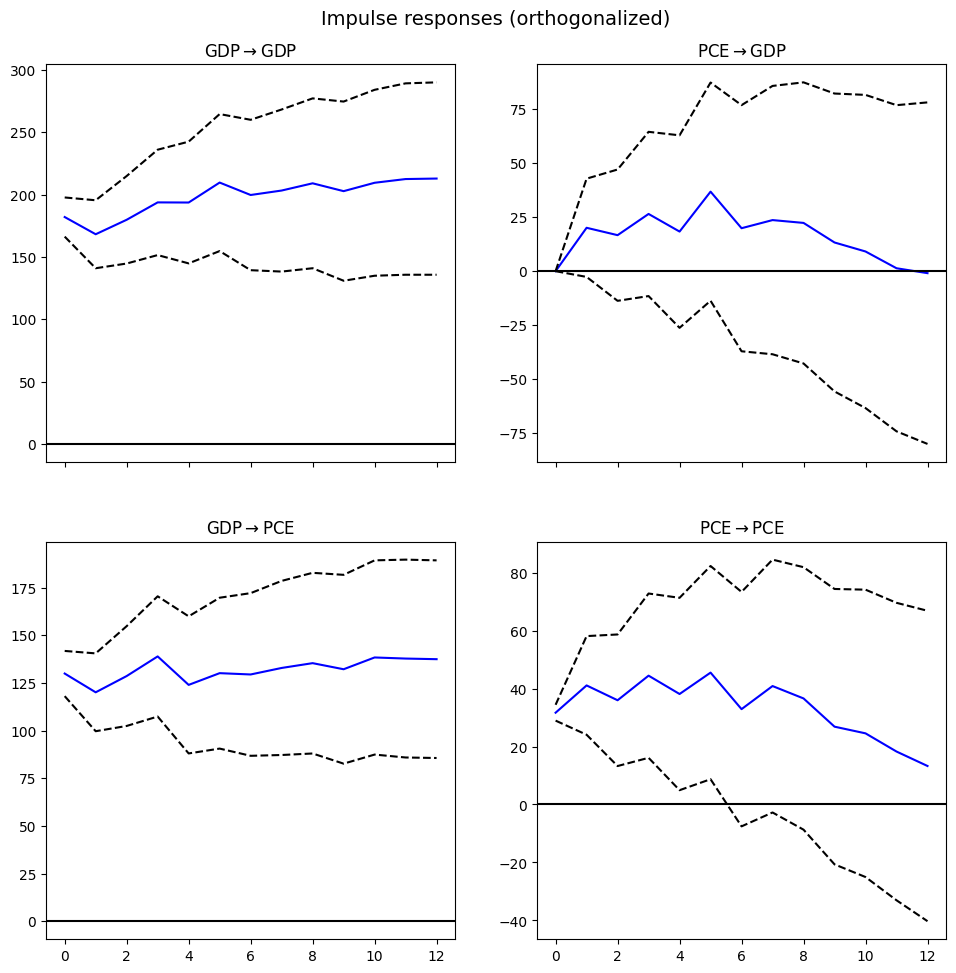

In [ ]:
# df_merged has columns ['GDP', 'PCE'] indexed by quarterly dates
# df_log = np.log(df_merged[['GDP', 'PCE']])

# Select lag order with information criteria
model = VAR(df_merged)
lag_selection = model.select_order(maxlags=8)  # quarterly data: up to 8 lags
print(lag_selection.summary())

# Fit VAR with chosen lag (e.g., AIC)
p = lag_selection.aic
var_res = model.fit(p)
print(var_res.summary())

# Structural identification: short-run (Cholesky) with variable ordering
# Assumption: GDP is contemporaneously exogenous relative to PCE (GDP first)
irf = var_res.irf(12)  # horizon 12 quarters

# Plot IRFs
fig = irf.plot(orth=True)  # orth=True uses Cholesky identification This step right here is us making an assumption to identify the structural shocks.
plt.show()

#### VAR breakdown and answering questions

##### Structural Shock Assumptions
We made an assumption on the structural shocks by using Cholesky decomposition. As I read about what that means it's rather neat. So, from what I understand GDP affects PCE, when GDP is ordered first, but PCE doesn't affect GDP when GDP is ordered first. This makes GDP contemporaneously exogenous. So, this means that a shock to GDP can affect PCE within the same quarter, (or whatever frequency the x-axis is set at I'm assuming) but a shock to PCE doesn't reciprocate onto GDP. Order matters here so I'd expect PCE to be contemporaneously exogenous to GDP given it was ordered first. In this context I'd think GDP affect PCE more than PCE would affect GDP, but from a modeling standpoint I can flip-flop the ordering.

##### Why does this requires assumptions and how do they lead to the identification of structural shocks?
We need assumptions because wihtout them we just have correlated OLS residuals for two variables. In order to extract some sort of inference we need to add some structure into it. This is where assumptions come in. If we use Cholesky decomposition we position the variables in an order that allows us to extract meaning from these correlated residuals. 
This allows us to label the shocks and from those labeled shocks we can compute our IRFs.
This concept of breaking correlation between the two variables made me think of how IV allow us to break the correlation with the error term and endogenous regressors. So, I guess instruments are like the assumptions we make in VAR modeling in order to extract meaningful inference. I know they're different and used in different scenarios, but the idea of adding an assumption made me think of 2SLS.

##### Plot interpretation
The x-axis is our time frequency, or in our case, quarters(about 3 months in a quarter). The blue line is the estimated impulse response from a one-unit shock, and the dotted black lines are the 95% confidence intervals. This feels like a linear regression because it basically is. We are using Vector Autoregressive modeling which is using OLS(Ordinary Least Squares), but a big difference is the multivariate dynamic structure. So, in the GDP --> GDP plot we are using GDP's own shocks to predict where GDP will go next quarter. We get a similar story for the GDP --> PCE plot because we made the Cholesky assumption which puts the variable GDP before PCE. Now let's look at PCE --> GDP, we can see we started at 0 and pass the threshold of 0 with one of the dotted-black lines. This happens because we put the GDP variable in front of PCE, and GDP is now contemporaneous exogenous relative to PCE. So, to sum it up, GDP shocks make an immediate effect on PCE, while PCE shocks have a delayed or no effect on GDP. This is expected due to the Cholesky assumption we are using to ensure that our residuals are able to be labeled so that we can get some inference from them.